# Ejercicio: Proyecto Molibdeno

## Enunciado

Ha recibido Vd. esta carta. Adopte el papel del destinatario y actúe en consecuencia justificando sus decisiones.


> Estimado Director de Proyectos:
> 
> En relación con nuestra anterior conversación telefónica, le adjunto los detalles del proyecto “Molibdeno”, del que ha pasado a ser máximo responsable, y sobre el que  cuelga la amenaza de sufrir retrasos. Como ya habrá leído en nuestra última circular, a fin de salvar el bache económico actual, su correcta gestión económica es de vital importancia, pues la nefasta gestión del responsable de la negociación del contrato nos carga con unas penalizaciones por retraso de diez u.m./periodo, doble de lo habitual en este tipo de proyectos.
>
> Le anticipo una buena noticia. Con el cambio de Director de Proyecto, también cambiaremos de contratista principal para desarrollar las tareas del proyecto que restan por comenzar. La empresa anterior, “Borum”, dispone de una plantilla limitada, 150 técnicos, y eso le impide aceptar modificaciones en relación con las tareas ya comenzadas. El nuevo contratista, “Calcium”, dispone de 200 técnicos y nos asegura su disponibilidad y cooperación frente a cualquier modificación respecto a la planificación inicial.
>
> El Consejo de Administración desea tener en cuenta su valoración acerca de la actuación del anterior gestor, así como también agradecería que le proporcionara una enumeración justificada de las actuaciones que llevará a cabo a efectos de gestionar correctamente el proyecto. 
>
> Reciba un cordial saludo.



Los datos del proyecto se encuentran en el fichero 'csv_files/datos_enunciado_molibdeno.csv' que se muestra a continuación

In [1]:
# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
datos_enunciado = pd.read_csv("csv_files/datos_enunciado_molibdeno.csv", sep=';', na_values='----', index_col='actividad')
datos_enunciado

,precedente,duracion_planificada,duracion_real,coste_planificado,coste_real,coste_tiempo_tope,tiempo_tope,realizado,recursos,varianza_duracion,duracion_pesimista
actividad,,,,,,,,,,,
A,NaN,5,7.0,70,77.0,100,2,100,5,1,15
B,NaN,3,8.0,48,56.0,58,1,100,10,2,9
C,NaN,4,5.0,40,45.0,66,2,100,15,3,12
D,B,4,5.0,40,50.0,94,2,100,5,9,12
E,B,3,3.0,18,21.0,37,1,100,15,5,9
F,B,3,4.0,36,40.0,58,1,100,15,4,9
G,"A, D",4,6.0,96,90.0,111,1,100,10,6,12
H,F,4,6.0,48,42.0,120,2,100,5,7,12
I,"C, E",6,7.0,210,189.0,140,3,100,5,3,18


## Solución
### Importamos librerías de Python.
En pmule (project management at ULE) está el código que utilizamos para calcular los valores del PERT.

In [2]:
from pmule import GrafoProyecto, ValorGanado

La clase GrafoProyecto permite visualizar el grafo PERT, el diagrama de Gantt así como realizar el cálculo de tiempos tempranos, tardíos y de las holguras totales.

In [3]:
aristas = pd.DataFrame([
    ('A', 1, 3),
    ('B', 1, 2),
    ('C', 1, 5),
    ('D', 2, 3),
    ('E', 2, 5),
    ('F', 2, 4),
    ('G', 3, 6),
    ('H', 4, 7),
    ('I', 5, 7),
    ('J', 6, 8),
    ('K', 7, 8),
    ('L', 7, 9),
    ('M', 7, 10),
    ('N', 7, 11),
    ('O', 8, 12),
    ('P', 9, 13),
    ('Q', 10, 14),
    ('R', 11, 15),
    ('S', 12, 16),
    ('T', 16, 18),
    ('U', 13, 18),
    ('V', 14, 18),
    ('W', 15, 17),
    ('X', 17, 18),
    ('f1', 4, 6),
    ('f2', 5, 6),
], columns=['actividad', 'nodo_inicial', 'nodo_final']).set_index('actividad')

In [4]:
datos_proyecto = pd.concat([datos_enunciado, aristas], axis=1, sort=False).set_index(aristas.index).fillna(0)
datos_proyecto

,precedente,duracion_planificada,duracion_real,coste_planificado,coste_real,coste_tiempo_tope,tiempo_tope,realizado,recursos,varianza_duracion,duracion_pesimista,nodo_inicial,nodo_final
actividad,,,,,,,,,,,,,
A,0,5.0,7.0,70.0,77.0,100.0,2.0,100.0,5.0,1.0,15.0,1,3
B,0,3.0,8.0,48.0,56.0,58.0,1.0,100.0,10.0,2.0,9.0,1,2
C,0,4.0,5.0,40.0,45.0,66.0,2.0,100.0,15.0,3.0,12.0,1,5
D,B,4.0,5.0,40.0,50.0,94.0,2.0,100.0,5.0,9.0,12.0,2,3
E,B,3.0,3.0,18.0,21.0,37.0,1.0,100.0,15.0,5.0,9.0,2,5
F,B,3.0,4.0,36.0,40.0,58.0,1.0,100.0,15.0,4.0,9.0,2,4
G,"A, D",4.0,6.0,96.0,90.0,111.0,1.0,100.0,10.0,6.0,12.0,3,6
H,F,4.0,6.0,48.0,42.0,120.0,2.0,100.0,5.0,7.0,12.0,4,7
I,"C, E",6.0,7.0,210.0,189.0,140.0,3.0,100.0,5.0,3.0,18.0,5,7


In [5]:
proyecto = GrafoProyecto(datos_proyecto)

### Grafo PERT de la planificación inicial

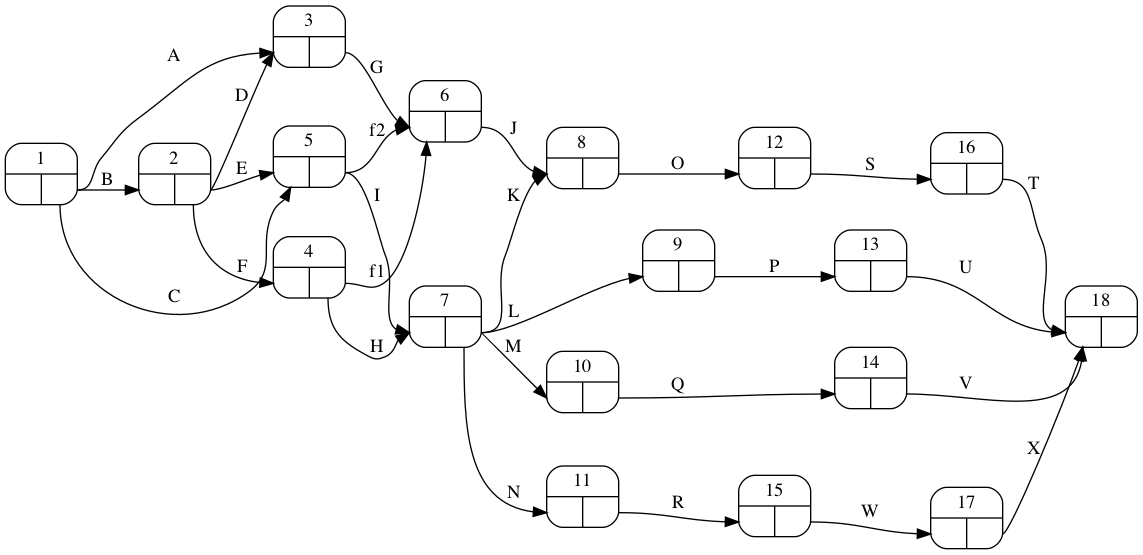

In [6]:
proyecto.pert(duraciones=False)

El proyecto tenía una duración prevista de 31 periodos.
Como alternativa al grafo PERT podemos representar el diagrama de Gantt.

### Diagrama de Gantt

In [7]:
proyecto.gantt(duraciones=datos_proyecto['duracion_planificada'],
               representar='nombres')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
A,A,A,A,A,A,,,,,,,,,,,,,,,,,,,,,,,,,,
B,B,B,B,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C,C,C,C,C,,,,,,,,,,,,,,,,,,,,,,,,,,,
D,,,,D,D,D,D,,,,,,,,,,,,,,,,,,,,,,,,
E,,,,E,E,E,,,,,,,,,,,,,,,,,,,,,,,,,
F,,,,F,F,F,,,,,,,,,,,,,,,,,,,,,,,,,
G,,,,,,,,G,G,G,G,,,,,,,,,,,,,,,,,,,,
H,,,,,,,H,H,H,H,,,,,,,,,,,,,,,,,,,,,
I,,,,,,,I,I,I,I,I,I,,,,,,,,,,,,,,,,,,,
J,,,,,,,,,,,,J,J,J,J,J,,,,,,,,,,,,,,,


### Demanda de recursos
Hecho el diagrama de Gantt anterior resulta fácil comprobar si la demanda de recursos supone alguna dificultad en algun momento del proyecto.

In [8]:
gantt_recursos = proyecto.gantt(duraciones=datos_proyecto['duracion_planificada'],
                                representar='recursos',
                                total='fila')
gantt_recursos

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
A,5,5,5,5,5,,,,,,,,,,,,,,,,,,,,,,,,,,
B,10,10,10,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C,15,15,15,15,,,,,,,,,,,,,,,,,,,,,,,,,,,
D,,,,5,5,5,5,,,,,,,,,,,,,,,,,,,,,,,,
E,,,,15,15,15,,,,,,,,,,,,,,,,,,,,,,,,,
F,,,,15,15,15,,,,,,,,,,,,,,,,,,,,,,,,,
G,,,,,,,,10,10,10,10,,,,,,,,,,,,,,,,,,,,
H,,,,,,,5,5,5,5,,,,,,,,,,,,,,,,,,,,,
I,,,,,,,5,5,5,5,5,5,,,,,,,,,,,,,,,,,,,
J,,,,,,,,,,,,15,15,15,15,15,,,,,,,,,,,,,,,


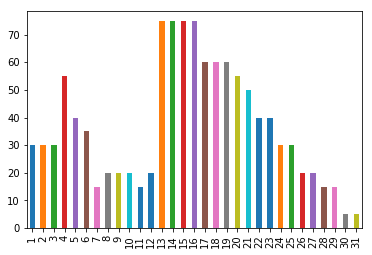

In [9]:
gantt_recursos.data.loc['Total'].plot(kind='bar');

Estos resultados confirman que el uso de recursos no presenta ningún problema en este proyecto, ni con la plantilla del contratista anterior ni con la del nuevo, por ser muy inferior a la plantilla disponible de técnicos.

# Método del valor ganado

La evaluación del estado actual del proyecto puede realizarse a través del método del valor ganado. Para ello se utilizará el diagrama de Gantt mostrado anteriormente y el correspondiente a las duraciones reales.

In [10]:
proyecto.gantt(duraciones=datos_proyecto['duracion_real'],
               representar='nombres')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
A,A,A,A,A,A,A,A,,,,,,,,,,,,,,,
B,B,B,B,B,B,B,B,B,,,,,,,,,,,,,,
C,C,C,C,C,C,,,,,,,,,,,,,,,,,
D,,,,,,,,,D,D,D,D,D,,,,,,,,,
E,,,,,,,,,E,E,E,,,,,,,,,,,
F,,,,,,,,,F,F,F,F,,,,,,,,,,
G,,,,,,,,,,,,,,G,G,G,G,G,G,,,
H,,,,,,,,,,,,,H,H,H,H,H,H,,,,
I,,,,,,,,,,,,I,I,I,I,I,I,I,,,,
J,,,,,,,,,,,,,,,,,,,,J,J,J


La clase ValorGanado es la responsable de realizar los cálculos del método.

In [11]:
vg = ValorGanado(proyecto)

In [12]:
gantts = vg.calcula_gantts(duraciones_planificadas   = datos_proyecto['duracion_planificada'],
                           duraciones_reales         = datos_proyecto['duracion_real'],
                           costes_planificados       = datos_proyecto['coste_planificado'],
                           costes_reales             = datos_proyecto['coste_real'],
                           porcentaje_de_completacion= datos_proyecto['realizado'])


In [13]:
gantts['Gantt_PV']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,Total
A,14,14,14,14,14,,,,,,,,,,,,,,,,,,,,,,,,,,,70
B,16,16,16,,,,,,,,,,,,,,,,,,,,,,,,,,,,,48
C,10,10,10,10,,,,,,,,,,,,,,,,,,,,,,,,,,,,40
D,,,,10,10,10,10,,,,,,,,,,,,,,,,,,,,,,,,,40
E,,,,6,6,6,,,,,,,,,,,,,,,,,,,,,,,,,,18
F,,,,12,12,12,,,,,,,,,,,,,,,,,,,,,,,,,,36
G,,,,,,,,24,24,24,24,,,,,,,,,,,,,,,,,,,,,96
H,,,,,,,12,12,12,12,,,,,,,,,,,,,,,,,,,,,,48
I,,,,,,,35,35,35,35,35,35,,,,,,,,,,,,,,,,,,,,210
J,,,,,,,,,,,,9,9,9,9,9,,,,,,,,,,,,,,,,45


In [14]:
gantts['Gantt_AC']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,Total
A,11,11,11,11,11,11,11,,,,,,,,,,,,,,,,77
B,7,7,7,7,7,7,7,7,,,,,,,,,,,,,,,56
C,9,9,9,9,9,,,,,,,,,,,,,,,,,,45
D,,,,,,,,,10,10,10,10,10,,,,,,,,,,50
E,,,,,,,,,7,7,7,,,,,,,,,,,,21
F,,,,,,,,,10,10,10,10,,,,,,,,,,,40
G,,,,,,,,,,,,,,15,15,15,15,15,15,,,,90
H,,,,,,,,,,,,,7,7,7,7,7,7,,,,,42
I,,,,,,,,,,,,27,27,27,27,27,27,27,,,,,189
J,,,,,,,,,,,,,,,,,,,,14,14,14,42


In [15]:
gantts['Gantt_EV']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,Total
A,10,10,10,10,10,10,10,,,,,,,,,,,,,,,,70
B,6,6,6,6,6,6,6,6,,,,,,,,,,,,,,,48
C,8,8,8,8,8,,,,,,,,,,,,,,,,,,40
D,,,,,,,,,8,8,8,8,8,,,,,,,,,,40
E,,,,,,,,,6,6,6,,,,,,,,,,,,18
F,,,,,,,,,9,9,9,9,,,,,,,,,,,36
G,,,,,,,,,,,,,,16,16,16,16,16,16,,,,96
H,,,,,,,,,,,,,8,8,8,8,8,8,,,,,48
I,,,,,,,,,,,,30,30,30,30,30,30,30,,,,,210
J,,,,,,,,,,,,,,,,,,,,15,15,15,45


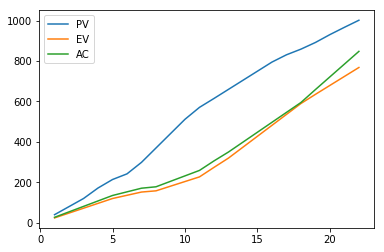

In [16]:
acumulados = gantts['acumulados']
acumulados.plot();

In [17]:
acumulados.tail(1)

,PV,EV,AC
22,1002,768.3,848


El análisis del valor ganado indica que el proyecto va con retraso y sobrecoste.

### Cálculo de la duración prevista del proyecto

Para el cálculo de la duración prevista a la luz de la información recogida se asume que para:
   - las actividades ya terminadas se utilizará su duración real;
   - las actividades comenzadas pero no completadas lo harán a la velocidad seguida hasta ahora;
   - las actividades que no han comenzado, su duración prevista es la correspondiente a la planificación inicial.

In [18]:
datos_proyecto_actualizado = datos_proyecto.copy()

empezadas = datos_proyecto_actualizado['realizado'] > 0
datos_proyecto_actualizado.loc[empezadas, 'duracion_planificada']  = 100 * datos_proyecto.loc[empezadas, 'duracion_real'] / datos_proyecto.loc[empezadas, 'realizado']
datos_proyecto_actualizado.loc[~empezadas, 'duracion_planificada'] = datos_proyecto.loc[~empezadas, 'duracion_planificada']

datos_proyecto_actualizado['duracion_planificada']

actividad
A      7.0
B      8.0
C      5.0
D      5.0
E      3.0
F      4.0
G      6.0
H      6.0
I      7.0
J      3.0
K      8.0
L     10.0
M      5.0
N      8.0
O      4.0
P      3.0
Q      3.0
R      3.0
S      3.0
T      3.0
U      3.0
V      4.0
W      3.0
X      4.0
f1     0.0
f2     0.0
Name: duracion_planificada, dtype: float64

Una vez obtenidas las duraciones previstas de las actividades, se puede calcular la nueva fecha de fin de proyecto.

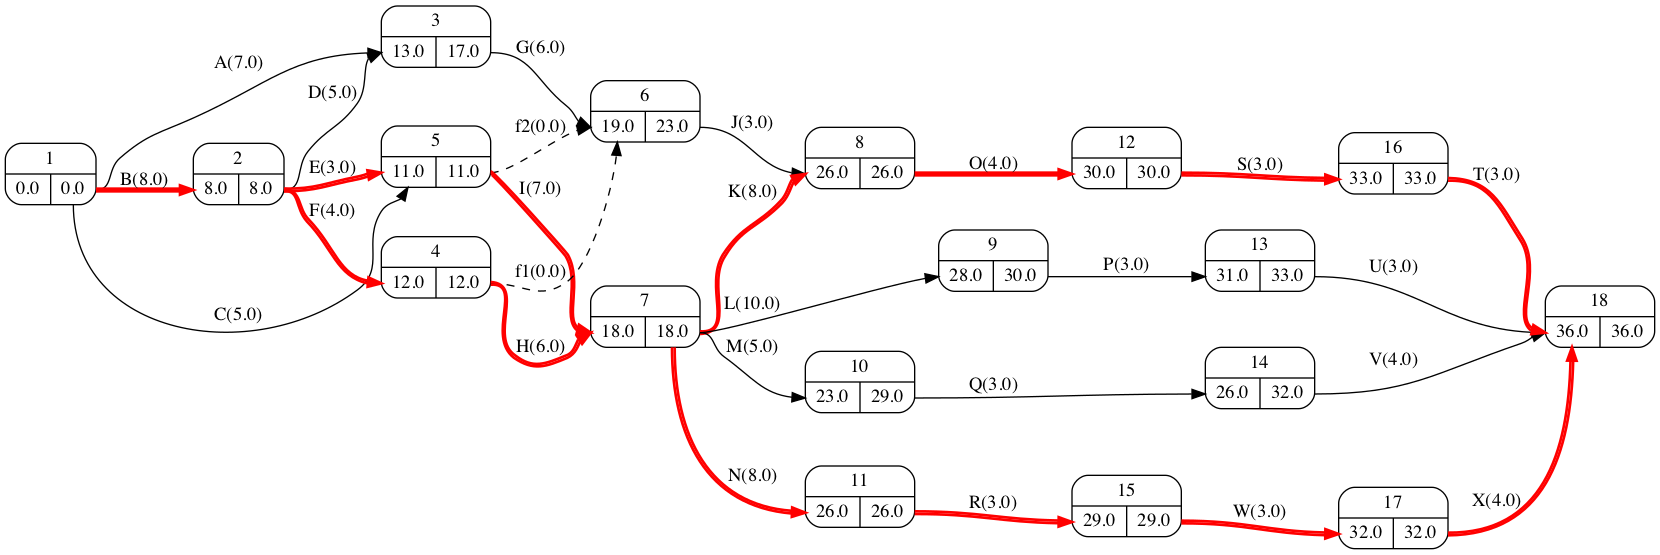

In [19]:
proyecto.pert(duraciones=datos_proyecto_actualizado['duracion_planificada'])

El proyecto presenta ahora una nueva duración de 36 periodos.
De modo alternativo, se puede llegar a igual resultado representando el diagrama de Gantt.

In [20]:
proyecto.gantt(duraciones=datos_proyecto_actualizado['duracion_planificada'],
               representar='nombres')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
A,A,A,A,A,A,A,A,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B,B,B,B,B,B,B,B,B,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C,C,C,C,C,C,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D,,,,,,,,,D,D,D,D,D,,,,,,,,,,,,,,,,,,,,,,,
E,,,,,,,,,E,E,E,,,,,,,,,,,,,,,,,,,,,,,,,
F,,,,,,,,,F,F,F,F,,,,,,,,,,,,,,,,,,,,,,,,
G,,,,,,,,,,,,,,G,G,G,G,G,G,,,,,,,,,,,,,,,,,
H,,,,,,,,,,,,,H,H,H,H,H,H,,,,,,,,,,,,,,,,,,
I,,,,,,,,,,,,I,I,I,I,I,I,I,,,,,,,,,,,,,,,,,,
J,,,,,,,,,,,,,,,,,,,,J,J,J,,,,,,,,,,,,,,


### Análisis de los costes incurridos por penalización vs. los costes derivados de la reducción de la duración del proyecto

Esta nueva situación tiene como consecuencia un retraso de 5 periodos con respecto a la planificación inicial. Dadas las penalizaciones por retraso del enunciado, las actuaciones del Director del Proyecto irán encaminadas a paliar el efecto negativo de este retraso. Para analizar de manera más simple la situación actual y presentar una estrategia de actuación se considera únicamente la parte de proyecto que resta por terminar.

In [21]:
datos_proyecto_simplificado = (datos_proyecto
                                  .query('realizado != 100')
                                  .drop(['f1', 'f2'])
                                  .rename(columns={'duracion_planificada':'duracion', 'tiempo_tope':'duracion_tope'})
                                  .eval('cur=(coste_tiempo_tope - coste_planificado)/(duracion - duracion_tope)')
                                  .drop(['precedente', 'recursos', 'varianza_duracion', 'duracion_pesimista'], axis=1)          
                                  .copy()
                              )
datos_proyecto_simplificado.loc[['K', 'L', 'M', 'N'], 'cur'] = np.inf

empezadas = datos_proyecto_simplificado['realizado'] > 0
datos_proyecto_simplificado.loc[empezadas,:] = datos_proyecto_simplificado.eval('duracion = (100 - realizado) * duracion_real / realizado')

datos_proyecto_simplificado.drop(['duracion_real', 'coste_planificado', 'coste_real', 'coste_tiempo_tope', 'realizado'], axis=1, inplace=True)
datos_proyecto_simplificado

,duracion,duracion_tope,nodo_inicial,nodo_final,cur
actividad,,,,,
K,4.0,1.0,7,8,inf
L,6.0,1.0,7,9,inf
M,1.0,1.0,7,10,inf
N,4.0,1.0,7,11,inf
O,4.0,2.0,8,12,8.000000
P,3.0,1.0,9,13,7.000000
Q,3.0,1.0,10,14,8.000000
R,3.0,1.0,11,15,5.000000
S,3.0,1.0,12,16,6.000000


In [22]:
proyecto_simplificado = GrafoProyecto(datos_proyecto_simplificado)

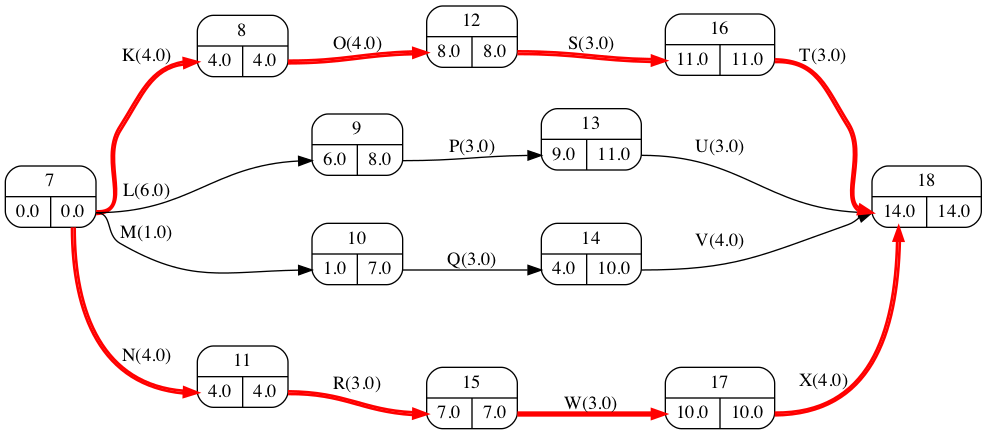

In [23]:
proyecto_simplificado.pert()

A fin de paliar el efecto del retraso y no pagar un exceso en penalizaciones, se considera la reducción de la duración del proyecto con mínimo coste.

Se pretende intentar valorar si un recorte en la duración del proyecto con mínimo coste puede compensar el sobrecoste por penalización.

#### Primera iteración: Pasar de 14 periodos a 13.
El camino crítico tiene dos ramas:

In [24]:
rama_1 = ['K', 'O', 'S', 'T']
rama_2 = ['N', 'R', 'W', 'X']

In [25]:
proyecto_simplificado.cur_ordenado(rama_1)

,cur,duracion,duracion_tope
actividad,,,
S,6.000000,3.0,1.0
T,7.000000,3.0,1.0
O,8.000000,4.0,2.0
K,inf,4.0,1.0


In [26]:
proyecto_simplificado.cur_ordenado(rama_2)

,cur,duracion,duracion_tope
actividad,,,
W,3.000000,3.0,1.0
R,5.000000,3.0,1.0
X,9.000000,4.0,2.0
N,inf,4.0,1.0


   - En la rama K-O-S-T la actividad con menor CUR es la S con un coste de 6 unidades
   - En la rama N-R-W-X la actividad con menor CUR es la W con un coste de 3 unidades


In [27]:
proyecto_simplificado.reducir(S = 1, W = 1)

Sobrecoste de la reducción: 9.0


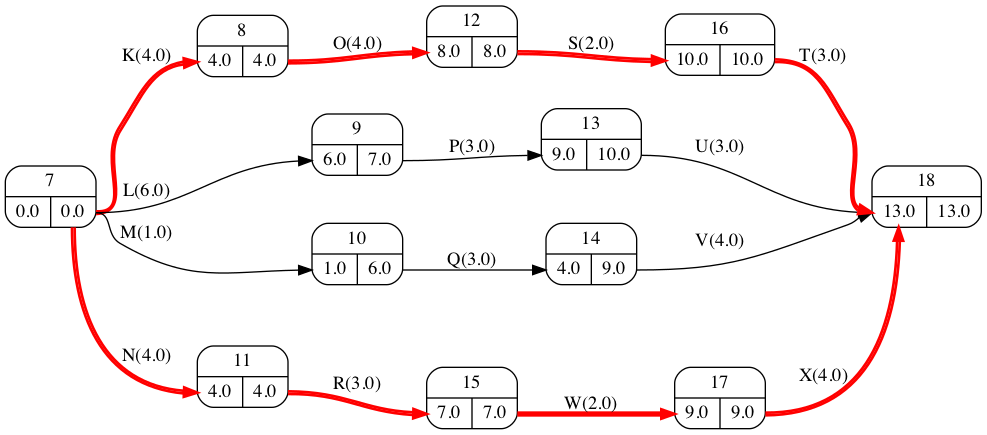

In [28]:
proyecto_simplificado.pert()

#### Segunda iteración: Pasar de 13 periodos a 12
El camino crítico tiene dos ramas:

In [29]:
proyecto_simplificado.cur_ordenado(rama_1)

,cur,duracion,duracion_tope
actividad,,,
S,6.000000,2.0,1.0
T,7.000000,3.0,1.0
O,8.000000,4.0,2.0
K,inf,4.0,1.0


In [30]:
proyecto_simplificado.cur_ordenado(rama_2)

,cur,duracion,duracion_tope
actividad,,,
W,3.000000,2.0,1.0
R,5.000000,3.0,1.0
X,9.000000,4.0,2.0
N,inf,4.0,1.0


   - En la rama K-O-S-T la actividad con menor CUR es la S con un coste de 6 unidades
   - En la rama N-R-W-X la actividad con menor CUR es la W con un coste de 3 unidades

El coste de la reducción asociado a esta iteración es 9 unidades

In [31]:
proyecto_simplificado.reducir(S = 1, W = 1)

Sobrecoste de la reducción: 9.0


Las actividades S y W han llegado a su duración tope y por tanto no se podrán recortar más.

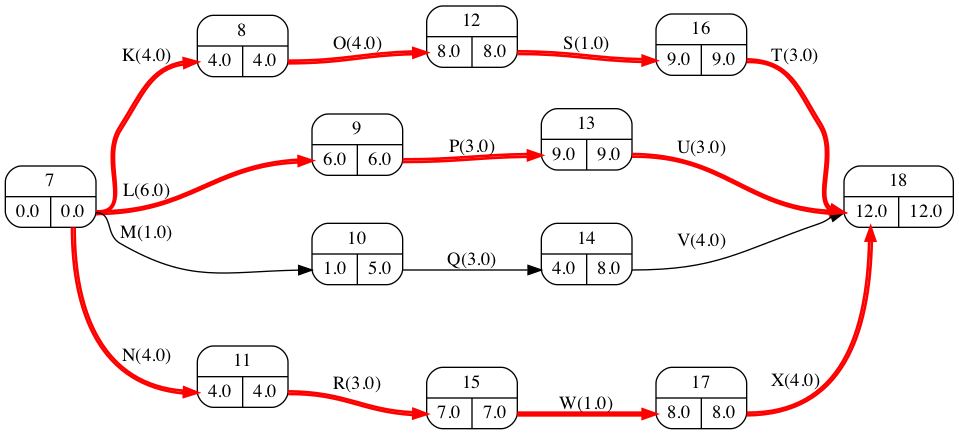

In [32]:
proyecto_simplificado.pert()

#### Tercera iteración: Pasar de 12 periodos a 11
El camino crítico tiene tres ramas:

In [33]:
rama_3 = ['L', 'P', 'U']

In [34]:
proyecto_simplificado.cur_ordenado(rama_1)

,cur,duracion,duracion_tope
actividad,,,
S,6.000000,1.0,1.0
T,7.000000,3.0,1.0
O,8.000000,4.0,2.0
K,inf,4.0,1.0


In [35]:
proyecto_simplificado.cur_ordenado(rama_2)

,cur,duracion,duracion_tope
actividad,,,
W,3.000000,1.0,1.0
R,5.000000,3.0,1.0
X,9.000000,4.0,2.0
N,inf,4.0,1.0


In [36]:
proyecto_simplificado.cur_ordenado(rama_3)

,cur,duracion,duracion_tope
actividad,,,
U,3.000000,3.0,1.0
P,7.000000,3.0,1.0
L,inf,6.0,1.0


   - En la rama K-O-S-T la actividad recortable con menor CUR es la T con un coste de 7 unidades
   - En la rama L-P-U la actividad con menor CUR es la U con un coste de 3 unidades
   - En la rama N-R-W-X la actividad recortable con menor CUR es la R con un coste de 5 unidades

El coste de la reducción de esta iteración es 15 u.m.

In [37]:
proyecto_simplificado.reducir(T = 1, U = 1, R = 1)

Sobrecoste de la reducción: 15.0


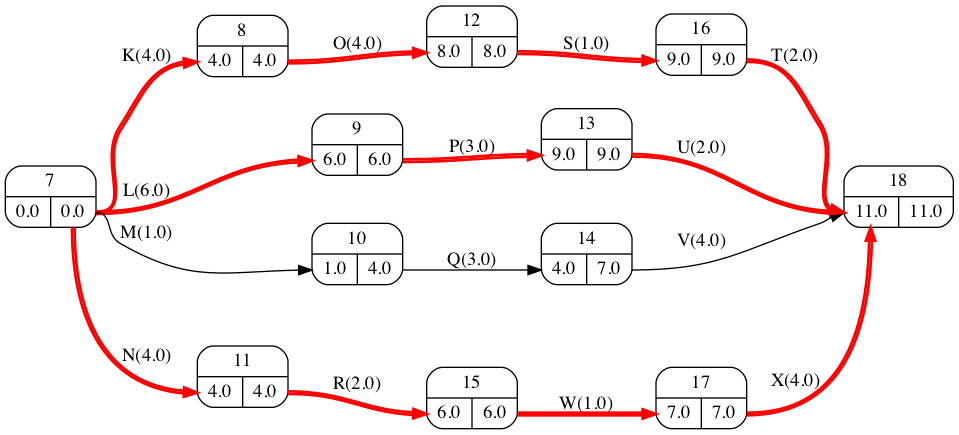

In [38]:
proyecto_simplificado.pert()

#### Cuarta iteración: Pasar de 11 periodos a 10
El camino crítico tiene tres ramas:

In [39]:
proyecto_simplificado.cur_ordenado(rama_1)

,cur,duracion,duracion_tope
actividad,,,
S,6.000000,1.0,1.0
T,7.000000,2.0,1.0
O,8.000000,4.0,2.0
K,inf,4.0,1.0


In [40]:
proyecto_simplificado.cur_ordenado(rama_2)

,cur,duracion,duracion_tope
actividad,,,
W,3.000000,1.0,1.0
R,5.000000,2.0,1.0
X,9.000000,4.0,2.0
N,inf,4.0,1.0


In [41]:
proyecto_simplificado.cur_ordenado(rama_3)

,cur,duracion,duracion_tope
actividad,,,
U,3.000000,2.0,1.0
P,7.000000,3.0,1.0
L,inf,6.0,1.0


   - En la rama K-O-S-T la actividad recortable con menor CUR es la T con un coste de 7 unidades
   - En la rama L-P-U la actividad con menor CUR es la U con un coste de 3 unidades
   - En la rama N-R-W-X la actividad recortable con menor CUR es la R con un coste de 5 unidades

El coste de la reducción de esta iteración es 15 u.m.

In [42]:
proyecto_simplificado.reducir(T = 1, U = 1, R = 1)

Sobrecoste de la reducción: 15.0


Las actividades T, U y R ya han alcanzado su tiempo tope y no se podrán recortar más.

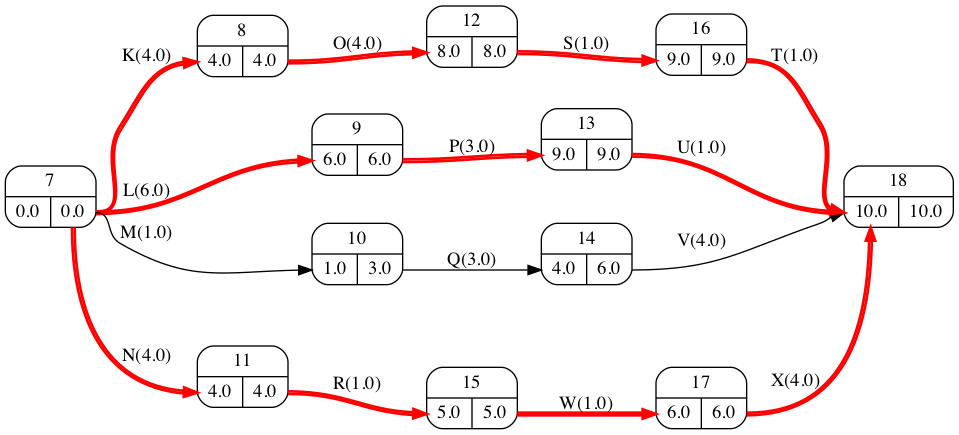

In [43]:
proyecto_simplificado.pert()

#### Quinta iteración: Pasar de 10 periodos a 9
El camino crítico tiene tres ramas:

In [44]:
proyecto_simplificado.cur_ordenado(rama_1)

,cur,duracion,duracion_tope
actividad,,,
S,6.000000,1.0,1.0
T,7.000000,1.0,1.0
O,8.000000,4.0,2.0
K,inf,4.0,1.0


In [45]:
proyecto_simplificado.cur_ordenado(rama_2)

,cur,duracion,duracion_tope
actividad,,,
W,3.000000,1.0,1.0
R,5.000000,1.0,1.0
X,9.000000,4.0,2.0
N,inf,4.0,1.0


In [46]:
proyecto_simplificado.cur_ordenado(rama_3)

,cur,duracion,duracion_tope
actividad,,,
U,3.000000,1.0,1.0
P,7.000000,3.0,1.0
L,inf,6.0,1.0


   - En la rama K-O-S-T la actividad recortable con menor CUR es la O con un coste de 8 unidades
   - En la rama L-P-U la actividad con menor CUR es la P con un coster de 7 unidades
   - En la rama N-R-W-X la actividad recortable con menor CUR es la X con un coste de 9 unidades

El coste de la reducción de esta iteración es 24 unidades.

In [47]:
proyecto_simplificado.reducir(O = 1, P = 1, X = 1)

Sobrecoste de la reducción: 24.0


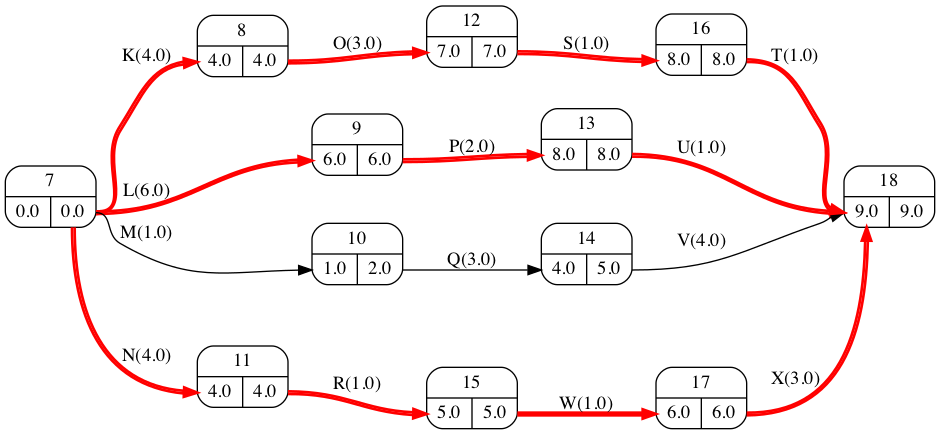

In [48]:
proyecto_simplificado.pert()

En este punto ya hemos analizado la reducción de los 5 periodos de retraso. Los costes son:

In [49]:
costes = pd.DataFrame({'reduccion': [0,
                                     0 + 9,
                                     0 + 9 + 9,
                                     0 + 9 + 9 + 15,
                                     0 + 9 + 9 + 15 + 15,
                                     0 + 9 + 9 + 15 + 15 + 24],
                       'penalizacion':[50, 40, 30, 20, 10, 0]},
                      index=[36, 35, 34, 33, 32, 31])
costes['agregados'] = costes['reduccion'] + costes['penalizacion']

In [50]:
costes

,reduccion,penalizacion,agregados
36,0,50,50
35,9,40,49
34,18,30,48
33,33,20,53
32,48,10,58
31,72,0,72


La suma de costes agregados resultante de sumar los costes de reducción acumulados más los costes de penalización acumulados indican que la operación más ventajosa desde el punto de vista de estos costes es reducir el proyecto hasta dejar su duración en 34 periodos.